imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import pickle
import gc

### Para guardar os dados em disco

In [2]:
def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
            return to_return
    except:
        print('Fail to load data')
        return None

meta data

In [3]:
df = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


distribuição das classes

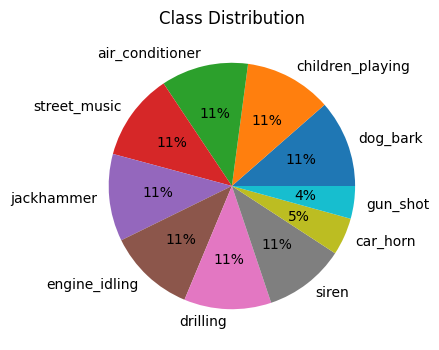

In [4]:
df['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

feature extraction and pre-processing

Padding of the Audio to a Fixed Length

In [5]:
import os

def padding(path, duration = 4, sr = 22050, files_limit = -1, verbose = False):
    files = librosa.util.find_files(path)
    data = []

    for index, file_path in enumerate(files):
        if files_limit != -1 and index >= files_limit:
            break
        if verbose:
            print(f"Processing audio {index + 1}/{len(files)}")
        try:
            audio, _ = librosa.load(file_path, sr=sr, mono=True)

            audio = np.pad(audio, (0, max(0, duration*sr - len(audio))), mode='constant')
            audio = audio[:duration * sr]

            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception:
            print(f"Error in processig file {file_path}: {Exception}")

    return data

feature extraction

In [6]:
def feature_extraction(dataframe, audios, hop_length = 512, n_fft = 512):
    log_spectograms = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]

                if not row.empty:
                    label = row.iloc[0,6]
                    spectogram = np.abs(librosa.core.stft(
                        y = np.array(audios[index][1]),
                        hop_length = hop_length,
                        n_fft = n_fft
                    ))
                    log_spectogram = librosa.amplitude_to_db(spectogram)
                    log_spectograms.append(log_spectogram)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    log_spectograms = np.array(log_spectograms)
    labels = np.array(labels)
    return log_spectograms, labels

data normalization and pre-processing

In [7]:
fold_paths = ["../UrbanSound8K/audio/fold1",
              "../UrbanSound8K/audio/fold2",
              "../UrbanSound8K/audio/fold3",
              "../UrbanSound8K/audio/fold4",
              "../UrbanSound8K/audio/fold5",
              "../UrbanSound8K/audio/fold6",
              "../UrbanSound8K/audio/fold7",
              "../UrbanSound8K/audio/fold8",
              "../UrbanSound8K/audio/fold9",
              "../UrbanSound8K/audio/fold10"]

In [8]:
features = np.empty((10,), dtype=object)
label = np.empty((10,), dtype=object)

for i, fold in enumerate(fold_paths):
    print(f"Processing Fold Number {i+1}")
    audio_data = padding(fold)

    log_spectograms, labels = feature_extraction(df, audio_data)
    log_spectograms_normalized = (log_spectograms - np.mean(log_spectograms)) / np.std(log_spectograms)
    log_spectograms_normalized = log_spectograms_normalized.transpose(0,2,1)
    
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    
    features[i] = log_spectograms_normalized
    label[i] = encoded_labels
    print("Features Shape: ",features[i].shape)
    print("Labels Shape: ",label[i].shape,"\n")
    
    del log_spectograms
    del log_spectograms_normalized
    del encoded_labels
    gc.collect() # libertar memoria


Processing Fold Number 1
Features Shape:  (873, 173, 257)
Labels Shape:  (873, 10) 

Processing Fold Number 2
Features Shape:  (888, 173, 257)
Labels Shape:  (888, 10) 

Processing Fold Number 3
Features Shape:  (925, 173, 257)
Labels Shape:  (925, 10) 

Processing Fold Number 4
Features Shape:  (990, 173, 257)
Labels Shape:  (990, 10) 

Processing Fold Number 5
Features Shape:  (936, 173, 257)
Labels Shape:  (936, 10) 

Processing Fold Number 6
Features Shape:  (823, 173, 257)
Labels Shape:  (823, 10) 

Processing Fold Number 7
Features Shape:  (838, 173, 257)
Labels Shape:  (838, 10) 

Processing Fold Number 8
Features Shape:  (806, 173, 257)
Labels Shape:  (806, 10) 

Processing Fold Number 9
Features Shape:  (816, 173, 257)
Labels Shape:  (816, 10) 

Processing Fold Number 10
Features Shape:  (837, 173, 257)
Labels Shape:  (837, 10) 



### Model Architecture

#### 1. Input Layer
- Shape: (x, y) where:
  - x is the number of timesteps (sequence length).
  - y is the number of features per timestep (e.g., MFCC coefficients).
- Purpose: The model expects a sequential input where each timestep represents a feature vector of the audio signal.
#### 2. First Bidirectional LSTM Layer
Description: A Bidirectional LSTM with 128 units.
- Bidirectionality: Processes the sequence in both forward and backward directions to capture dependencies in the audio signal from past and future timesteps.
- Activation: tanh for non-linearity.
- Kernel Initialization: glorot_uniform for balanced weight initialization.
- Output: Produces a sequence of 128 features for each timestep.
- Dropout (0.3): <b>Randomly drops 30% of connections to prevent overfitting.</b>
- Batch Normalization: <b>Normalizes the output of the LSTM layer, ensuring stability during training by keeping activations in a consistent range.</b>

#### 3. Second Bidirectional LSTM Layer
Description: Another Bidirectional LSTM with 128 units.
- Purpose: Further refines temporal features extracted from the first LSTM layer, learning more complex patterns.
- Output: Produces a sequence of 128 features for each timestep.
- Dropout (0.3): <b>Again, drops 30% of connections for regularization.</b>
- Batch Normalization: <b>Stabilizes activations and accelerates convergence.</b>

#### 4. TimeDistributed Dense Layers
Description: Fully connected layers applied independently to each timestep. These layers transform the feature representation at each timestep into higher-level abstractions.
- First Dense Layer:
  - Units: 128 neurons.
  - Activation: ReLU for faster training and reduced vanishing gradient issues.
  - Regularization: L2 regularization (0.01) to prevent overfitting.
  - Dropout (0.2): Drops 20% of connections.
- Second Dense Layer:
  - Units: 64 neurons.
  - Activation: ReLU.
  - Regularization: L2 regularization (0.01).
  - Dropout (0.2).
  - Purpose: These layers learn high-level feature transformations for each timestep.

#### 5. Flatten Layer
Description: Flattens the outputs of the TimeDistributed Dense layers into a single vector.
- Purpose: Converts the 2D sequence of features into a 1D vector suitable for final classification.

#### 6. Output Layer
Description: A fully connected Dense layer with 10 neurons.
- Activation: Softmax, which outputs a probability distribution over the 10 sound classes.
- Purpose: Final classification into one of the 10 categories.

In [9]:
from tensorflow.keras import Sequential, regularizers, layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten, BatchNormalization

def create_bidirectional_model(x, y):
    input_shape = (x, y)  # Shape of X_train sample

    model = Sequential()

    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.2))

    # Flatten layer
    model.add(Flatten())

    # Fully connected output layer
    model.add(Dense(10, activation='softmax'))

    return model


In [10]:
#model = create_bidirectional_model(345, 513)
model = create_bidirectional_model(173, 257)
model.summary()

c:\Users\joaob\Documents\GitHub\Sound_Classification\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 173, 256)       │       395,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 173, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 173, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 173, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 173, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 173, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 173, 128)       │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 173, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 173, 64)        │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 173, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11072)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │       110,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,434 (3.60 MB)

 Trainable params: 942,410 (3.60 MB)

 Non-trainable params: 1,024 (4.00 KB)

training strategies

### novo

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
import numpy as np

fold_metrics = []
EPOCHS = 50
fold = 0  # Current fold to be used as test set

print(f"Fold {fold+1}:")

# Initialize lists for train/test sets
X_train, y_train = [], []
X_test, y_test = None, None

# Splitting the data into Train, Test, and Validation sets
for i in range(10):
    if i != fold:
        # Append data for training
        if len(X_train) == 0:  # Initialize for the first fold
            X_train = features[i]
            y_train = label[i]
        else:
            X_train = np.concatenate((X_train, features[i]), axis=0)
            y_train = np.concatenate((y_train, label[i]), axis=0)
    else:
        # Set test data
        X_test = features[i]
        y_test = label[i]

# Split test set into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

# Convert data to numpy arrays if not already
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Print set shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model
LSTM = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=64, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)

# Predict unseen data
y_pred = model.predict(X_test)

# Evaluate the model
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# Save fold results
m_metrics = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM.history
}

fold_metrics.append(m_metrics)

model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
save_pkl(fold_metrics, f"kfold_metrics_LSTM/metrics{fold+1}.pkl")

# Restart model to avoid memory leakage
del model
keras.backend.clear_session()

print("Done.")


Fold 1:
X_train Shape: (7859, 173, 257)
y_train Shape: (7859, 10)
X_test Shape: (436, 173, 257)
y_test Shape: (436, 10)
X_val Shape: (437, 173, 257)
y_val Shape: (437, 10)
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.1664 - loss: 5.7810 - val_accuracy: 0.3616 - val_loss: 3.8846
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.2609 - loss: 3.8188 - val_accuracy: 0.3112 - val_loss: 3.2518
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.2930 - loss: 3.2539 - val_accuracy: 0.3730 - val_loss: 2.7671
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3201 - loss: 2.8213 - val_accuracy: 0.3776 - val_loss: 2.4447
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3445 - loss: 2.4632 - val_accuracy: 0.3547 - val_loss: 2.5299
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3781 - loss: 2.2382 - val_accuracy: 0.3822 - val_loss: 2.2040
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step -

FileNotFoundError: [Errno 2] No such file or directory: 'kfold_metrics_LSTM/model_fold1.keras'

In [ ]:
epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(len(fold_metrics), 2, figsize=(10, 5*len(fold_metrics)))

i = 0
history_dict = fold_metrics[i].get('history_dict')
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']

ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
ax[i,0].set_xlabel('Epochs')
ax[i,0].set_ylabel('Loss')
ax[i,0].legend()

ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
ax[i,1].set_xlabel('Epochs')
ax[i,1].set_ylabel('Accuracy')
ax[i,1].legend()
plt.show()

In [ ]:
fig, ax =plt.subplots(5, 2, figsize=(15,3*len(fold_metrics)))

i = 0
cm = fold_metrics[i].get('confusion_matrix')
ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'cool', ax=ax[i//2,i%2])

plt.show()

### antigo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
fold_metrics = []
EPOCHS = 50
fold = 0

f = "fold" + str(fold+1)
print("Fold "+str(fold+1)+":")

X_train, y_train = [], []
X_test, y_test = [], []
    
# Splitting the data into Test, Validation and Training sets
for i in range(10):
    if( i != fold):
        X_train += features[i].tolist()
        y_train.extend(label[i])
        
    else:
        X_test = features[i]
        y_test = labels[i]

    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
        
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)

# Print sets shapes
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"X_val Shape: {X_val.shape}")


optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    optimizer = optimizer, 
    loss = 'categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model
LSTM = model.fit(
    X_train, y_train, 
    epochs = EPOCHS,
    batch_size = 64, 
    shuffle = False, 
    validation_data=(X_val, y_val)
)

# Predict unseen data
y_pred = model.predict(X_test)

y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# Save fold results
m_metrics = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 'history_dict': LSTM.history
}

fold_metrics.append(m_metrics)

model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
save_pkl(fold_metrics, f"kfold_metrics_LSTM/metrics{fold+1}.pkl")

# restart model to avoid memory leakage
del model 

print("Done.")

Fold 1:


performance evaluation